# ITSM 601 Semester Project
## Austin Animal Shelter Data
### Predicts Adopted/Not Adopted

Travis Lemon and John Bonfardeci
2018-04-08

#### What this notebook does:
* Create randomized K cross-validation (CV) groups
* For-each CV:
    * Split randomized data into (k-1)/k training data and 1/k testing
    * Run LDA K times
        * Find best cutoff (Youden's Index and Distance-to-corner) and test cutoff set
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
    * Run Logistic Regression K times
        * Find best cutoff (Youden's Index and Distance-to-corner) and test cutoff set
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
Directions in Jupyter Notebook: Select `Cell -> Run All`. 
Look for printed output and ROC plots at bottom of notebook.

In [1]:
# Change These Parameters           

# relative file path; can place in same working directory as notebook
file_path = 'animal_shelter_train.csv'

# the column names of the continuous predictors
feature_names = ['Cat', 'IntactFemale', 'IntactMale', 'NeuteredMale', 'SpayedFemale', 'AgeRange_0', 
                 'AgeRange_1_4', 'AgeRange_10_15', 'AgeRange_15_20', 'AgeRange_5_9', 'Black_Brown', 
                 'Black_Tan', 'Black_White', 'Blue', 'Blue Tabby', 'Blue_White', 'Brown', 'Brown_White', 
                 'Calico', 'OrangeTabby', 'Other', 'Red', 'Tan', 'Tortie', 'Tricolor', 'Yellow', 'MixBreed', 'PitBull']

# name of target column
target_name = 'Adopted'

# what value represents the positive value in a binary response: e.g. 1, 'Y', 'T', ...
target_value = 1 

# LDA Solver to use. 
#    Options: 
#        'lsqr' (Least squares solution) - can use with shrikage
#        'svd' (Singular value decomposition) - use with large num features
#        'eigen' (Eigenvalue decomposition) - can use with shrikage
# http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
lda_solver = 'lsqr'

# change to None to run LDA without shrinkage
# Options: None, 'auto', float between 0 and 1
# see http://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py
lda_shrinkgage = 'auto'

# number of cross-validation groups to run
num_cv = 5

output_data_to_excel = False


In [2]:
# Imports

import math
import pandas as pd
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from copy import copy

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import VarianceThreshold

In [3]:
# load the data into Pandas Dataframe object
usecols = copy(feature_names).append(target_name)

df = pd.read_csv(file_path, usecols=usecols) # returns new Pandas DataFrame 

# randomize rows (http://quabr.com/29576430/shuffle-dataframe-rows)
#df = _df.iloc[np.random.permutation(len(df))]

# create new series with target value converted to 1/0 for the binary responses
y = pd.Series( map(lambda x: 1 if x == target_value else 0, df[target_name]) ).as_matrix() # <class 'pandas.core.series.Series'>

# get our predictor variables as a multidimensional array (matrix)
X = df[feature_names].as_matrix() # <class 'pandas.core.frame.DataFrame'>

#cat = df[categorical_features].as_matrix() # <class 'pandas.core.frame.DataFrame'>

# check the X and y data
print(y[0:5])
print(X[0:5])

# good to go...

[1 1 1 0 1]
[[1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


In [4]:
def get_balanced_accuracy(tpr, fpr, cutoffs):
    """
    Balanced Accuracy.
    
    @param tpr: array<float> (True Positive Rate - the Sensitivity)
    @param fpr: array<float> (False Positive Rate - the Specificity)
    @param thresholds array<float> (list of thresholds)
    @returns dict
    """
    
    def invert_fpr(fpr):
        """ Invert (1-specificity) to specificity"""
        return 1.0 - fpr
    
    def fn(tpr, fpr): 
        return (tpr / invert_fpr(fpr)) / 2
    
    d = {'method': 'Balanced Accuracy', 
         'cutoff': 0,
         'tpr': 0, 
         'fpr': 0
        }
    
    # get values where tpr < 1.0
    t, f, c = tpr[tpr < 1.0], fpr[tpr < 1.0], cutoffs[tpr < 1.0]
    
    opt = fn(t[0], f[0])

    for (_tpr, _fpr, cutoff) in zip(t, f, c):
        n = fn(_tpr, _fpr)
        if n > opt:
            opt = n
            d['cutoff'] = cutoff
            d['tpr'] = _tpr
            d['fpr'] = _fpr
              
    return d

In [5]:
# Confusion Matrix
def get_confusion_matrix(cutoff, actual, predicted):
    """
    Putting a threshold/cutoff on the output of a regression problem, 
    to determine whether the value is greater or lower than a fixed threshold, 
    is a binary classification problem.
    
    For example: 
    
       n=165   | Predicted NO | Predicted YES
    ------------------------------------------
    Actual NO  |       50     |      10       |
    ------------------------------------------
    Actual YES |       5      |      100      |
    ------------------------------------------
    
    The diagonal elements represent the number of points for which the predicted label is equal to the true label,
    while off-diagonal elements are those that are mislabeled by the classifier.
    The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.
    """
    pred = []
    
    for (x, y) in predicted:
        pred.append(1 if y > cutoff else 0)

    return confusion_matrix(actual, pred)


def get_cutoff_index(cutoffs, cutoff, tol=0.1): 
    i = 0
    for c in cutoffs:
        if c >= cutoff and c <= (cutoff+tol):
            return i
        
        i += 1
        
    return -1    

In [6]:
def show_confusion_matrix(C,class_labels=['0','1'], figsize=(6,6), fontsize=12):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    https://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted', fontsize=fontsize)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('Actual', fontsize=fontsize, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [7]:
def show_roc(kfolds, mean_tpr, mean_fpr, title, lw=2):
    
    colors = cycle(['cyan', 'red', 'seagreen', 'darkorange', 'blue'])
    
    # Plot the ROC Curve for this CV group
    i=0
    for (k, color) in zip(kfolds, colors):
        tpr, fpr = k[0], k[1]
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
        i += 1
    
    # Plot the ROC Curve for logistic regression
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')

    mean_tpr /= len(kfolds)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive (1-Specificity)')
    plt.ylabel('True Positive (Sensitivity)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def output_cutoffs(fold_num, tpr, fpr, thresholds, prob):
    # output optimal cutoff/threshold points
    fold_num += 1
    
    print( "Fold %d" % (fold_num))
    print( "------")
    
    ba = get_balanced_accuracy(tpr, fpr, thresholds)
    ba_cm = get_confusion_matrix(ba['cutoff'], y[test], prob)
    print( "Fold %d: Balanced Accuracy cutoff = %0.5f" % (fold_num, ba['cutoff']))
    print( "Sensitivity: %0.5f, 1-Specificity: %0.5f" % (ba['tpr'], ba['fpr'])) 
    show_confusion_matrix(ba_cm)

    print( "\r\n")

In [9]:
#Output to Excel
def output_excel(filename, prob, x, y, predicted, sheetname='Sheet1'):

    col_names = np.append( np.asarray(feature_names), np.asarray([target_name, 'Prob[Y]', 'Prob[N]', 'Predicted']))    
    data = []
    
    #print "\r\nprob: %d, x: %d, y: %d, fpr: %d, tpr: %d, thresh: %d" % (len(prob), len(x), len(y), len(fpr), len(tpr), len(thresholds))
    
    i = 0
    for xrow, yrow, prob, pred in zip(x, y, prob, predicted):
        a = []
        for col in xrow:
            a.append(col)

        a.append(yrow)
        a.append(prob[0])
        a.append(prob[1])
        a.append(pred)
        data.append(a)
        i+=1

    df = pd.DataFrame(data=data, columns=col_names)
    writer = pd.ExcelWriter(filename+'.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name=sheetname)
    writer.save()
    

def output_roc(filename, sheetname, tpr, fpr, cutoffs):
    #print "tpr: %d, fpr: %d, cutoffs: %d" % (len(tpr), len(fpr), len(cutoffs))
    
    data = []
    for (t, f, c) in zip(tpr, fpr, cutoffs):
        data.append([t, f, c])
        
    df = pd.DataFrame(data=data, columns=['Sensitivity', '1-Specificity', 'Cutoff'])
    writer = pd.ExcelWriter(filename+'.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name=sheetname)
    writer.save()
    

C:\Users\bonfardeci-j\Anaconda2\envs\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


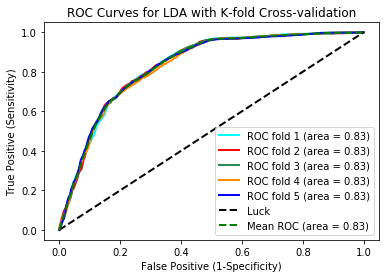

In [13]:
# Run LDA with cross-validation and plot ROC curves
rand = np.random.RandomState(0)
cv = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=rand)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
kfolds = []
i = 0
#mean_accuracy = 0

# For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
# TODO - add feature selection per CV
# train, test are of type <type 'numpy.ndarray'>
for (train, test) in cv.split(X, y):

    # train LDA on training dataset
    lda = LinearDiscriminantAnalysis(solver=lda_solver,  
                                     shrinkage=lda_shrinkgage).fit(X[train], y[train])
       
    # test LDA on test dataset
    prob = lda.predict_proba(X[test]) # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
    
    # gives you the predicted label for each sample
    # default threshold/cutoff is 0.5?
    train_predicted = lda.predict(X[train])
    predicted = lda.predict(X[test]) 
    
    # Compute ROC curve and area the curve
    # fpr = false positive rate (1-specificity)
    # tpr = true positive rate (sensitivity)
    fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
    
    # add mean Sensitivity
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0

    #accuracy = lda.score(X[test], y[test])
    #mean_accuracy += accuracy
    #print "Mean Accuracy of LDA Fold %d = %0.5f" % (i+1, accuracy)
    
    #output_cutoffs(i, tpr, fpr, thresholds, prob)
    
    if output_data_to_excel:
        output_excel('lda-fold-%d-test' % (i+1), prob, X[test], y[test], predicted, 'TestSet%d' % (i+1))
        output_excel('lda-fold-%d-train' % (i+1), lda.predict_proba(X[train]), X[train], y[train], train_predicted, 'TrainSet%d' % (i+1))
        output_roc('lda-roc-fold-%d-test'%(i+1), 'TestSet%d'%(i+1), tpr, fpr, thresholds)
    # /if...
    
    # Plot the ROC Curve for this CV group
    #plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    kfolds.append([tpr, fpr])
    i += 1
#/for (train, test)...

#print "\r\nMean Accuracy of LDA is %0.5f.\r\n" % (mean_accuracy/num_cv) 

show_roc(kfolds, mean_tpr, mean_fpr, 'ROC Curves for LDA with K-fold Cross-validation')

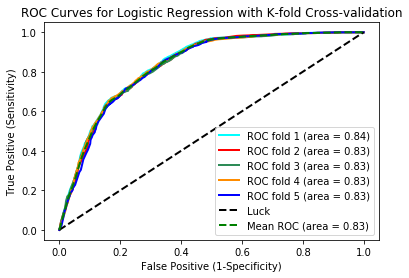

In [12]:
# Run logistic Regression with cross-validation and plot ROC curves
i=0
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
mean_accuracy = 0
kfolds = []
mean_accuracy = 0

for (train, test) in cv.split(X, y):

    logreg = LogisticRegression(C=1e5)
    logreg.fit(X[train], y[train])
    prob = logreg.predict_proba(X[test])
    train_predicted = logreg.predict(X[train])
    predicted = logreg.predict(X[test]) # 1/0

    # Compute ROC curve and area the curve
    # fpr = false positive rate (1-specificity)
    # tpr = true positive rate (sensitivity)
    fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
    
    # add mean Sensitivity
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    # get Area Under Curve
    roc_auc = auc(fpr, tpr)
    
    #accuracy = logreg.score(X[test], y[test])
    #print "Mean Accuracy of Log Reg Fold %d is %0.5f" % (i+1, accuracy)
    #mean_accuracy += accuracy
    
    #output_cutoffs(i, tpr, fpr, thresholds, prob)
    
    if output_data_to_excel:
        output_excel('logit-fold-%d-test' % (i+1), prob, X[test], y[test], predicted, 'TestSet%d' % (i+1))
        output_excel('logit-fold-%d-train' % (i+1), lda.predict_proba(X[train]), X[train], y[train], train_predicted, 'TrainSet%d' % (i+1))
        output_roc('logit-roc-fold-%d-test'%(i+1), 'TestSet%d'%(i+1), tpr, fpr, thresholds)
    # /if...
    
    kfolds.append([tpr, fpr])
    i += 1
#/for (train, test)...

show_roc(kfolds, mean_tpr, mean_fpr, 'ROC Curves for Logistic Regression with K-fold Cross-validation')
#print "\r\nMean Accuracy of Log Reg is %0.5f.\r\n" % (mean_accuracy/num_cv) 